# Choose sessions

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('./style.mplstyle')
IMG_DPI = 100

from src.lib.csv import read

BASELINE = "data/jason-verus-v3/session_20240901_100156_thunderhill_east_bypass_lap2_1_v3.csv"
EXPERIMENT = "data/seigo/59.8-lap-brz-thill-east.csv"

baseline = read(BASELINE)[1]
experiment = read(EXPERIMENT)[0]

OIL_P = 'oil_p'
OIL_T = 'oil_t'

/Users/brianarmstrong/Developer/900BRZ/fa24d/src/lib/csv/reader/abstract_csv_reader.py:98: RankWarning: Polyfit may be poorly conditioned
  oil_p_regression_line = np.polyfit(
/Users/brianarmstrong/Developer/900BRZ/fa24d/src/lib/csv/reader/abstract_csv_reader.py:98: RankWarning: Polyfit may be poorly conditioned
  oil_p_regression_line = np.polyfit(


# Oil pressure data

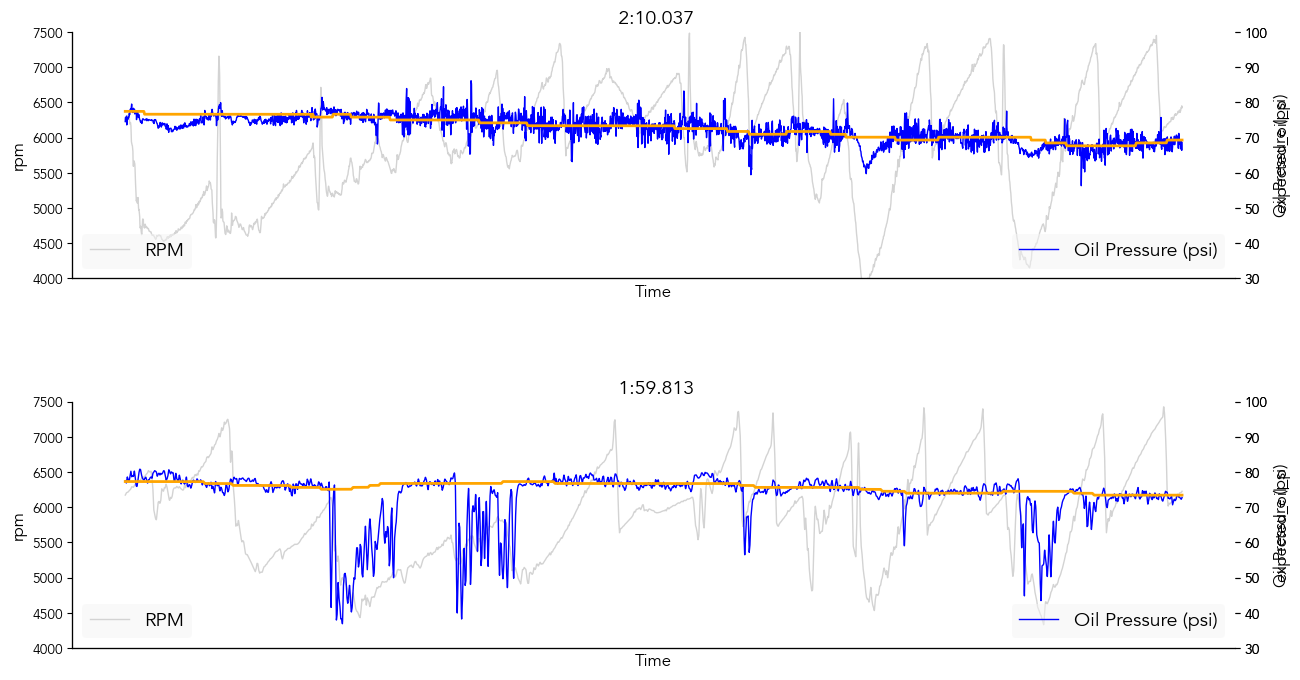

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(15,8))
axes.flatten()

for i, lap in enumerate((baseline, experiment)):
    df = lap.data
    # create a dual axis plot if desired

    primary = axes[i]
    secondary = primary.twinx()
    tertiary = primary.twinx()

    primary.set_title(lap.humanized_time, fontsize=14)

    primary.set_xlabel("")
    
    sns.lineplot(ax = secondary, x = df.index, y = 'oil_p', data = df, lw = 1, color='blue', label = "Oil Pressure (psi)", legend=False)
    sns.lineplot(ax = primary, x = df.index, y = 'rpm', data = df, lw = 1, color='lightgray', label = "RPM", legend=False)
    sns.lineplot(ax = tertiary, x = df.index, y = 'expected_oil_p', data = df, lw = 2, color='orange', label = "Oil Temp (F)", legend=False)

    primary.set_ylim([4000,7500])

    secondary.set_ylim([30,100])
    tertiary.set_ylim([30,100])

    secondary.set_ylabel('Oil Pressure (psi)')
    
    primary.legend(loc='lower left')
    secondary.legend(loc='lower right')

    # hide x axis units
    primary.set_xticklabels([])
    primary.set(xticks=[])
    primary.set_xlabel('Time')
    
fig.subplots_adjust(hspace=0.5)
fig.savefig(f'./figures/oilp-raw.png', bbox_inches='tight', facecolor='w', dpi=IMG_DPI)

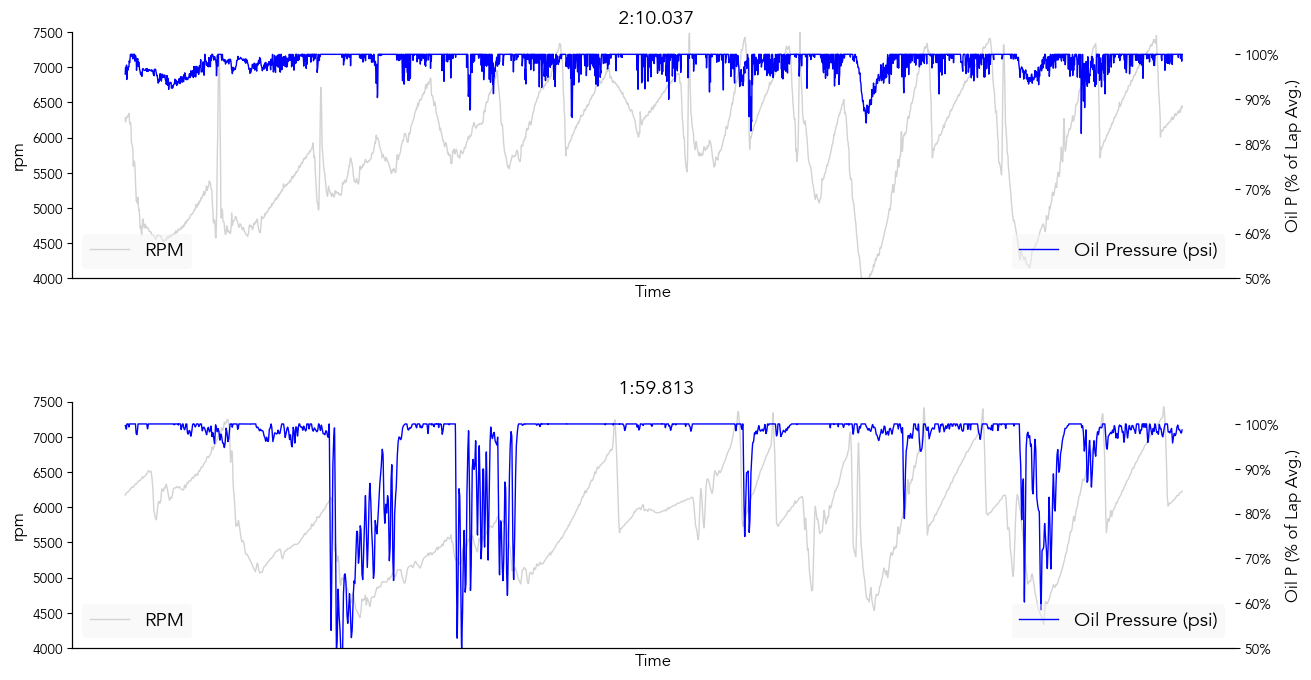

In [3]:


fig, axes = plt.subplots(2, 1, figsize=(15,8))
axes.flatten()

for i, lap in enumerate((baseline, experiment)):
    df = lap.data

    lat_accel = axes[i]
    oil_p = lat_accel.twinx()

    sns.lineplot(ax = lat_accel, x = df.index, y = "rpm", data = df, lw = 1, color='lightgray', label = "RPM", legend=False)
    sns.lineplot(ax = oil_p, x = df.index, y = "normalized_oil_p_drop_percent", data = df, lw = 1, color='blue', label = "Oil Pressure (psi)", legend=False)

    lat_accel.set_title(lap.humanized_time, fontsize=14)

    oil_p.set_ylim([50,105])
    lat_accel.set_ylim([4000,7500])

    lat_accel.legend(loc='lower left')
    oil_p.legend(loc='lower right')

    # hide x axis units
    primary.set_xticklabels([])
    primary.set(xticks=[])
    primary.set_xlabel('')

    lat_accel.set_xlabel("Time")
    lat_accel.set_xticklabels([])
    lat_accel.set(xticks=[])

    oil_p.set_yticks([100, 90, 80, 70, 60, 50])
    oil_p.set_yticklabels(["100%", "90%", "80%", "70%", "60%", "50%"])
    oil_p.set_ylabel('Oil P (% of Lap Avg.)')
    
fig.subplots_adjust(hspace=0.5)

fig.savefig(f'./figures/oilp-normalized.png', bbox_inches='tight', facecolor='w', dpi=IMG_DPI)


# Correlations with rpm, oil temp

It is well established when oil pressure drops occur.
Some readings display right hand turns as negative Gs while others appear as positive Gs so it is always good to check.

Since oil pressure is also dependent on engine speed, it is good to factor in engine speed when examining low oil pressures

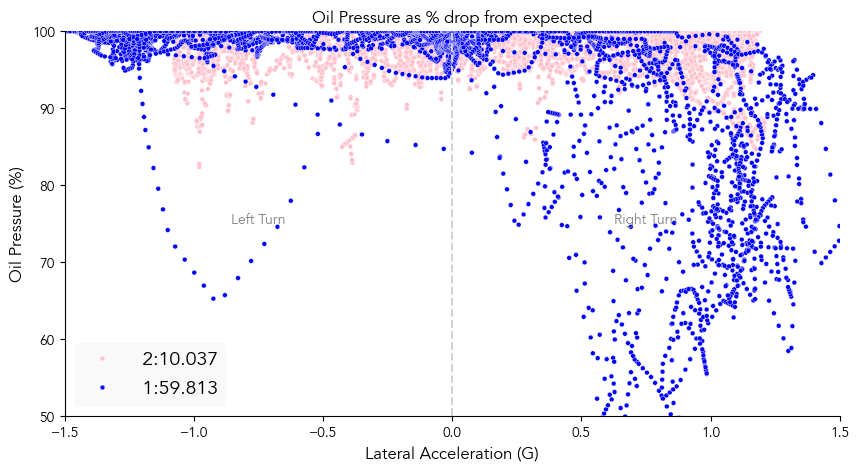

In [4]:
color_palette: dict[str, str] = {}

# currently only supports two sessions
colors = ["pink", "blue"]

for i, lap in enumerate((baseline, experiment)):
    color_palette[lap.humanized_time] = colors[i]
    lap.data["label"] = lap.humanized_time
    
fig, ax = plt.subplots(figsize=(10,5))

joined = pd.concat([baseline.data, experiment.data], ignore_index=True)

sns.scatterplot(ax = ax, x = "gps_lat_acc", y = 'normalized_oil_p_drop_percent', data = joined, hue="label", palette=color_palette, s=12, legend="auto")

ax.set_xlim([-1.5,1.5])
ax.set_title('Oil Pressure as % drop from expected')
ax.set_ylabel('Oil Pressure (%)')
ax.set_xlabel('Lateral Acceleration (G)')
ax.set_ylim([50, 100])
ax.get_legend().set_title(None)

ax.axvline(x=0, color='lightgray', linestyle='--')

# Add text labels
ax.text(0.75, 75, 'Right Turn', horizontalalignment='center', color='gray')
ax.text(-0.75, 75, 'Left Turn', horizontalalignment='center', color='gray')

fig.savefig(f'./figures/oilp-scatter-lap.png', bbox_inches='tight', facecolor='w', dpi=IMG_DPI)

# Plotting coordinates

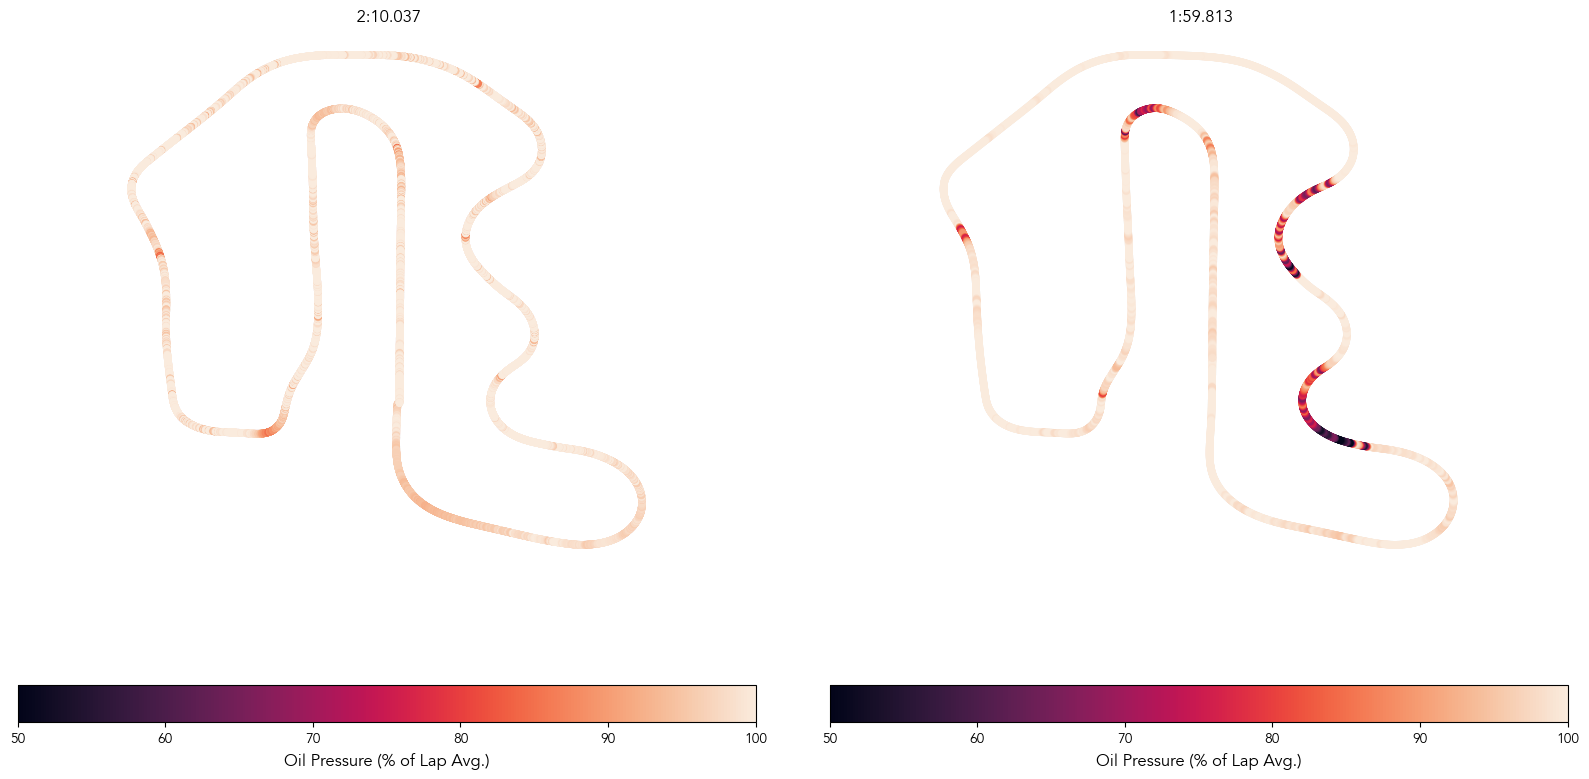

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
axs = ax.flatten()

for i, lap in enumerate((baseline, experiment)):
    df = lap.data

    gdf = gpd.GeoDataFrame(data = df, geometry = gpd.points_from_xy(df['gps_lon'], df['gps_lat']))

    a = axs[i]
    data = gdf

    data.plot(ax = a, column = "normalized_oil_p_drop_percent", legend=True, vmin=50, vmax=100, cmap="rocket", label = "Oil Pressure (%)", markersize=20, legend_kwds={'label': "Oil Pressure (% of Lap Avg.)", 'orientation': "horizontal"})

    a.set_title(lap.humanized_time)

    a.axis('off')

fig.subplots_adjust(wspace=.1)
fig.savefig(f'./figures/oilp-gps.png', bbox_inches='tight', facecolor='w', dpi=IMG_DPI)